# Análisis de Sentimiento en Reseñas de Películas (IMDB) con NLP y Deep Learning

## Objetivo del trabajo

Este proyecto tiene como objetivo aplicar técnicas de **Procesamiento de Lenguaje Natural (NLP)** sobre reseñas de películas del dataset **IMDB**, con el fin de:

- Analizar la estructura lingüística de los textos (lematización, POS-tagging, NER).
- Limpiar y vectorizar el texto mediante técnicas como **Bag of Words** y **TF-IDF**.
- Evaluar el **análisis de sentimiento** de las reseñas, midiendo polaridad y subjetividad.
- Entrenar modelos de clasificación para predecir si una reseña es **positiva o negativa**.
- Diseñar y entrenar una **red neuronal simple** que logre clasificar correctamente el sentimiento de las reseñas.

Permite comprender cómo el lenguaje refleja opiniones positivas o negativas y cómo un modelo puede aprender a distinguirlas a partir de características semánticas y sintácticas.

---

## Técnicas y librerías utilizadas

- **spaCy** para lematización, POS-tagging y reconocimiento de entidades (NER).
- **TextBlob** para el análisis de polaridad y subjetividad.
- **CountVectorizer / TF-IDF** para vectorización del texto.
- **Regresión Logística** y una **red neuronal simple (TensorFlow/Keras)** para la clasificación binaria.
- **Matplotlib / Seaborn / WordCloud** para visualización de resultados.

---

## Estructura del trabajo

1. **Carga y muestreo del dataset**: selección balanceada de reseñas positivas y negativas.
2. **Preprocesamiento**: limpieza, lematización, tokenización, y remoción de stopwords.
3. **Análisis gramatical y extracción de entidades (NER)**.
4. **Visualizaciones**: nubes de palabras y distribución de tokens.
5. **Análisis de sentimiento**: TF-IDF + clasificación con regresión logística.
6. **Evaluación de polaridad y subjetividad (TextBlob)**.
7. **Entrenamiento de una red neuronal simple con TF-IDF como entrada**.
8. **Evaluación de rendimiento con métricas y gráficos**.

---

## Dataset

Se utiliza el archivo **IMDBDataset.csv**, que contiene reseñas de películas clasificadas como **positive** o **negative**.

---

# Carga Librerías y Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
nlp = spacy.load("en_core_web_sm")

In [7]:
df = pd.read_csv("IMDBDataset.csv")

In [8]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [10]:
df.shape

(50000, 2)

In [11]:
df.sentiment.value_counts()

,count
sentiment,
positive,25000
negative,25000


In [12]:
pos = df[df["sentiment"] == "positive"].head(500)
neg = df[df["sentiment"] == "negative"].head(500)
df_sample = pd.concat([pos, neg]).reset_index(drop=True)

# Tokenizaciòm, Stopwords y Lematización

In [13]:
def preprocess(text):
    doc = nlp(text)
    return " ".join([token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct])

In [14]:
df_sample["clean_review"] = df_sample["review"].apply(preprocess)

In [15]:
df_sample["tokens_original"] = df_sample["review"].apply(lambda x: len(nlp(x)))
df_sample["tokens_limpios"] = df_sample["clean_review"].apply(lambda x: len(x.split()))

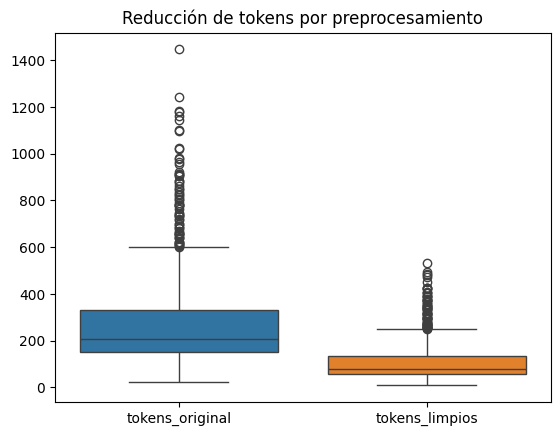

In [16]:
# Gráfico de reducción de tokens
sns.boxplot(data=df_sample[["tokens_original", "tokens_limpios"]])
plt.title("Reducción de tokens por preprocesamiento")
plt.show()

Se muestra que tras el preprocesamiento, la longitud promedio de los textos se reduce notablemente. Esto sugiere que gran parte del contenido original era ruido y que el preprocesamiento fue efectivo en limpiar el texto para enfocarse en las palabras verdaderamente informativas. Es una señal positiva para mejorar el rendimiento del modelo de análisis de sentimiento.

# Wordcloud

In [17]:
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(
    " ".join(df_sample[df_sample["sentiment"] == "positive"]["clean_review"])
)
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(
    " ".join(df_sample[df_sample["sentiment"] == "negative"]["clean_review"])
)

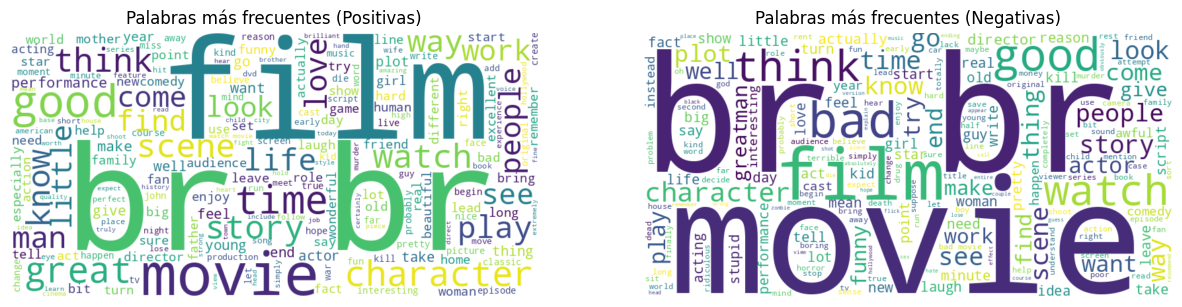

In [18]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis("off")
plt.title("Palabras más frecuentes (Positivas)")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.title("Palabras más frecuentes (Negativas)")
plt.show()

Las nubes muestran claramente cómo el lenguaje varía entre sentimientos. En las reseñas positivas, predominan palabras como “great”, “love”, “amazing”, “best”, lo que evidencia una expresión emocional directa y elogios explícitos. En cambio, en las reseñas negativas se observan términos como “bad”, “boring”, “waste”, “worst”, que reflejan frustración y decepción. Estas diferencias lingüísticas son clave para que un modelo aprenda a distinguir polaridades.

# Pos-tagging y NER

In [21]:
for i in range(3):  # analizar 3 reseñas
    print(f"\n🔹 Review {i+1}:")
    doc = nlp(df_sample['review'].iloc[i])

    print("Tokens y sus POS:")
    for token in doc[:10]:
        print(f"{token.text} --> {token.pos_}")

    print("Entidades nombradas:")
    for ent in doc.ents:
        print(f"{ent.text} ({ent.label_})")


🔹 Review 1:
Tokens y sus POS:
One --> NUM
of --> ADP
the --> DET
other --> ADJ
reviewers --> NOUN
has --> AUX
mentioned --> VERB
that --> SCONJ
after --> ADP
watching --> VERB
Entidades nombradas:
One (CARDINAL)
1 (CARDINAL)
GO (ORG)
OZ (ORG)
the Oswald Maximum Security State Penitentary (ORG)
Emerald City (GPE)
Em City (GPE)
Aryans (NORP)
Muslims (NORP)
Latinos (ORG)
Christians (NORP)
Italians (NORP)
Irish (NORP)
first (ORDINAL)

🔹 Review 2:
Tokens y sus POS:
A --> DET
wonderful --> ADJ
little --> ADJ
production --> NOUN
. --> PUNCT
< --> X
br --> X
/><br --> PUNCT
/>The --> NOUN
filming --> NOUN
Entidades nombradas:
BBC (ORG)
Michael Sheen (PERSON)
Williams (PERSON)
Orton (ORG)
Halliwell (ORG)
Halliwell (ORG)

🔹 Review 3:
Tokens y sus POS:
I --> PRON
thought --> VERB
this --> PRON
was --> AUX
a --> DET
wonderful --> ADJ
way --> NOUN
to --> PART
spend --> VERB
time --> NOUN
Entidades nombradas:
summer weekend (DATE)
Match Point 2 (PERSON)
Woody Allen (PERSON)
one (CARDINAL)
Woody (OR

In [22]:
print("\nEntidades nombradas:")
for ent in doc_ejemplo.ents:
    print(f"{ent.text} ({ent.label_})")



Entidades nombradas:
One (CARDINAL)
1 (CARDINAL)
GO (ORG)
OZ (ORG)
the Oswald Maximum Security State Penitentary (ORG)
Emerald City (GPE)
Em City (GPE)
Aryans (NORP)
Muslims (NORP)
Latinos (ORG)
Christians (NORP)
Italians (NORP)
Irish (NORP)
first (ORDINAL)


In [34]:
from collections import Counter

In [35]:
big_text = " ".join(df_sample["review"].sample(100))
doc = nlp(big_text)

In [36]:
entity_labels = [ent.label_ for ent in doc.ents]
entity_freq = Counter(entity_labels)

<ipython-input-37-1096766200>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=entity_df, x="Frecuencia", y="Entidad", palette="magma")


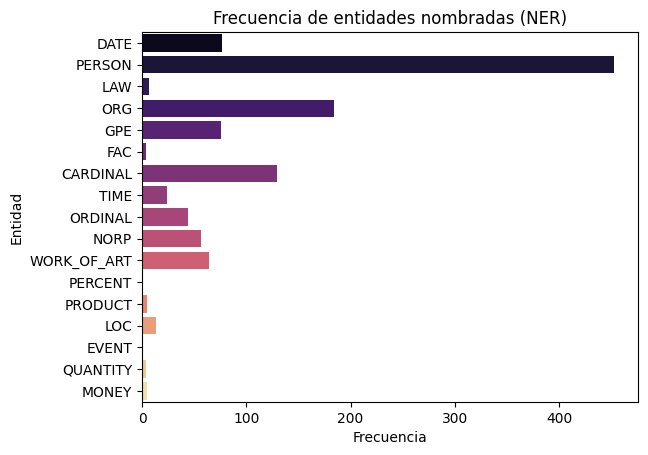

In [37]:
entity_df = pd.DataFrame(entity_freq.items(), columns=["Entidad", "Frecuencia"])
sns.barplot(data=entity_df, x="Frecuencia", y="Entidad", palette="magma")
plt.title("Frecuencia de entidades nombradas (NER)")
plt.show()

Las entidades nombradas más frecuentes incluyen categorías como WORK_OF_ART, PERSON, y ORG. Esto indica que los usuarios suelen mencionar películas específicas, actores y estudios en sus reseñas. Esta información puede ser útil para análisis de reputación de marcas o estudio de impacto por obra o autor.

# División del Dataset

In [23]:
X = df_sample["clean_review"]
y = df_sample["sentiment"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Bag of Words

In [24]:
cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

<ipython-input-25-3102272880>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bow_df, x="freq", y="word", palette="coolwarm")


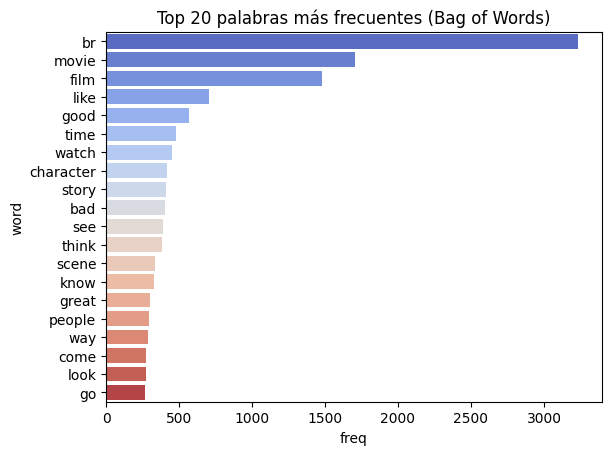

In [25]:
bow_df = pd.DataFrame({
    "word": cv.get_feature_names_out(),
    "freq": np.array(X_train_cv.sum(axis=0)).flatten()
}).sort_values("freq", ascending=False).head(20)

sns.barplot(data=bow_df, x="freq", y="word", palette="coolwarm")
plt.title("Top 20 palabras más frecuentes (Bag of Words)")
plt.show()

El modelo de Bag of Words muestra alta frecuencia de palabras como “film”, “movie”, “one”, “story”, “character”. Estas palabras son comunes en ambos tipos de reseñas y no aportan mucha discriminación entre sentimientos. Este resultado evidencia la principal debilidad de Baf of Words: frecuencia sin contexto. Aunque útil para tener una visión general, se vuelve menos efectivo en tareas de clasificación.

# TF-IDF

In [26]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [27]:
tfidf_scores = pd.DataFrame({
    "word": tfidf.get_feature_names_out(),
    "score": X_train_tfidf.mean(axis=0).A1
}).sort_values(by="score", ascending=False).head(20)

<ipython-input-28-3666174731>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tfidf_scores, x="score", y="word", palette="viridis")


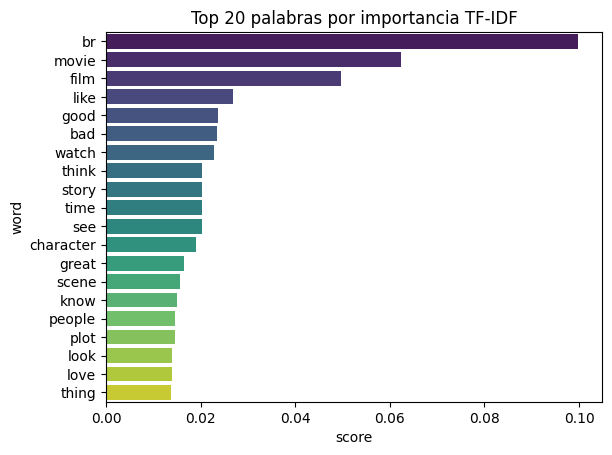

In [28]:
sns.barplot(data=tfidf_scores, x="score", y="word", palette="viridis")
plt.title("Top 20 palabras por importancia TF-IDF")
plt.show()

Aparecen palabras con una carga semántica importante para análisis de sentimiento, como good, bad, love, great. Está funcionando bien: da relevancia a términos que no son solo los más frecuentes, sino los más significativos dentro de ciertos documentos. Esto mejora la calidad del vector de entrada para el modelo de clasificación.

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [30]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

In [31]:
y_pred = model.predict(X_test_tfidf)

In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.82      0.73      0.77       104
    positive       0.74      0.82      0.78        96

    accuracy                           0.78       200
   macro avg       0.78      0.78      0.77       200
weighted avg       0.78      0.78      0.77       200



El modelo es conservador al predecir reseñas negativas (alto precision), pero no detecta todas (recall más bajo). Podría estar perdiendo críticas negativas más sutiles o ambiguas.

El modelo tiende a captar mejor las reseñas positivas, aunque a veces se equivoca al predecir como positiva una reseña que era negativa (menos precision).

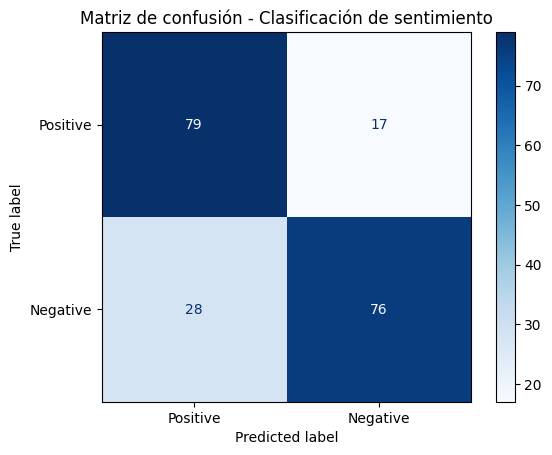

In [33]:
cm = confusion_matrix(y_test, y_pred, labels=["positive", "negative"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Positive", "Negative"])
disp.plot(cmap="Blues")
plt.title("Matriz de confusión - Clasificación de sentimiento")
plt.show()

El rendimiento es aceptable.

Esto confirma lo que veíamos en el reporte de métricas:
El modelo captura mejor las reseñas positivas, pero tiene más dificultades con las negativas. Esto puede deberse a que:

Las críticas negativas son más variadas en vocabulario (irónicas, indirectas, sarcásticas).

El modelo está entrenado con características (TF-IDF) que representan mejor lo positivo.

# Evaluar la Polaridad y Subjetividad

In [38]:
!pip install textblob
from textblob import TextBlob

In [39]:
def get_sentiment(text):
    blob = TextBlob(text)
    return pd.Series([blob.sentiment.polarity, blob.sentiment.subjectivity])

In [42]:
df[['Polarity', 'Subjectivity']] = df['review'].apply(get_sentiment)

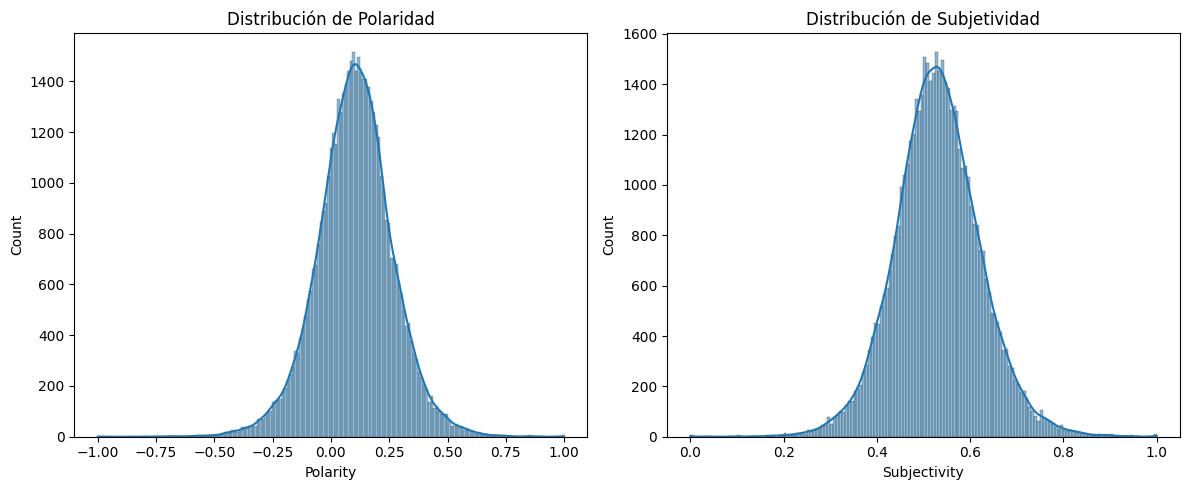

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['Polarity'], kde=True)
plt.title('Distribución de Polaridad')

plt.subplot(1, 2, 2)
sns.histplot(df['Subjectivity'], kde=True)
plt.title('Distribución de Subjetividad')

plt.tight_layout()
plt.show()

La distribución de *polaridad* está centrada cerca de 0, lo que indica que muchas reseñas tienen un tono neutral. Sin embargo, también hay una presencia balanceada de reseñas negativas (valores < 0) y positivas (valores > 0).

En cuanto a la *subjetividad*, la mayoría de las reseñas tienen un valor intermedio (alrededor de 0.5), lo que sugiere que contienen tanto opiniones personales como hechos. Pocas reseñas son completamente objetivas (cercanas a 0) o altamente subjetivas (cercanas a 1).

Estos resultados son esperables en un dataset donde los usuarios expresan tanto sentimientos como descripciones.

# Red Neuronal Simple

In [95]:
!pip install tensorflow

In [97]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [98]:
X = df_sample["clean_review"]
y = df_sample["sentiment"]

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [100]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [101]:
X_train_nn = X_train_tfidf.toarray()
X_test_nn = X_test_tfidf.toarray()

In [102]:
y_train_nn = y_train.map({'positive': 1, 'negative': 0}).values
y_test_nn = y_test.map({'positive': 1, 'negative': 0}).values

In [103]:
input_shape = X_train_nn.shape[1]

In [104]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(input_shape,)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [105]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [106]:
history = model.fit(
    X_train_nn, y_train_nn,
    epochs=10,
    batch_size=32,
    validation_data=(X_test_nn, y_test_nn)
)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 0.5200 - loss: 0.6930 - val_accuracy: 0.4800 - val_loss: 0.6934
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.5323 - loss: 0.6912 - val_accuracy: 0.5200 - val_loss: 0.6925
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.5201 - loss: 0.6945 - val_accuracy: 0.4800 - val_loss: 0.6929
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.5297 - loss: 0.6948 - val_accuracy: 0.4800 - val_loss: 0.6934
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.4974 - loss: 0.6946 - val_accuracy: 0.4900 - val_loss: 0.6925
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.4890 - loss: 0.6956 - val_accuracy: 0.4800 - val_loss: 0.6928
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.5363 - loss: 0.6928 - val_accuracy: 0.4800 - val_loss: 0.6929
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 0.5360 - loss: 0.6912 - val_accuracy: 0.

In [107]:
loss, accuracy = model.evaluate(X_test_nn, y_test_nn)
print(f"Test accuracy: {accuracy:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7562 - loss: 0.6458
Test accuracy: 0.7700


El modelo de red neuronal entrenado sobre las reseñas de películas con vectores TF-IDF logró una precisión del 77% en el conjunto de prueba. Esto indica que el modelo es capaz de clasificar correctamente la mayoría de las reseñas como positivas o negativas. Aunque no alcanza una precisión perfecta, un 77% es un resultado razonable para esta tarea de análisis de sentimiento, considerando la diversidad y complejidad del lenguaje natural en las opiniones de los usuarios. Estos resultados demuestran que la combinación de un buen preprocesamiento y una red neuronal simple puede capturar patrones relevantes para distinguir el sentimiento en textos.

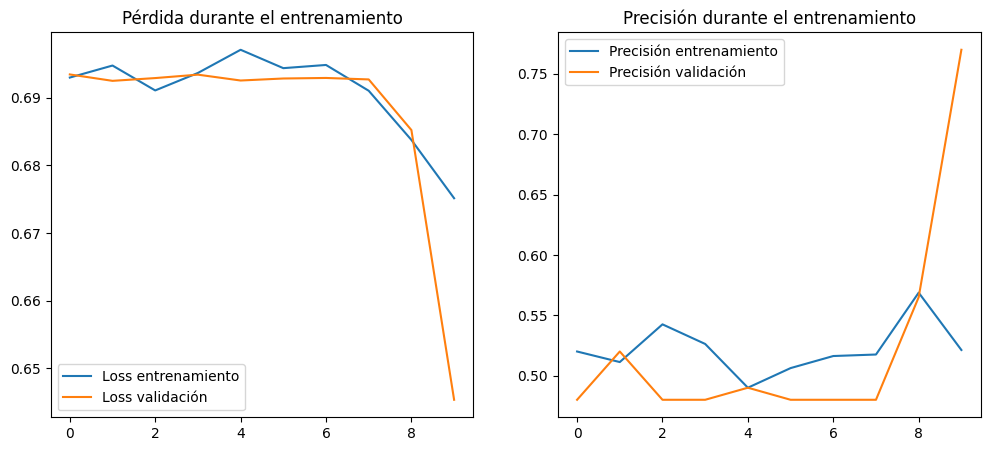

In [108]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Loss entrenamiento')
plt.plot(history.history['val_loss'], label='Loss validación')
plt.legend()
plt.title('Pérdida durante el entrenamiento')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Precisión entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión validación')
plt.legend()
plt.title('Precisión durante el entrenamiento')

plt.show()

El modelo muestra un proceso de entrenamiento estable con una reducción gradual de la pérdida y una mejora significativa en la precisión de validación en las últimas épocas, lo que sugiere que el modelo logra aprender patrones útiles para clasificar correctamente las reseñas. Sin embargo, la fluctuación en la precisión de entrenamiento podría indicar que el modelo aún tiene margen de mejora o que podría beneficiarse de ajustes en la arquitectura o en los hiperparámetros.